# Pose Linear Metrics Statistical Analysis

This notebook performs comprehensive statistical analysis on all pose linear metrics using mixed-effects models and generates publication-ready figures.

## Important
Before using this notebook:
1. Download the raw pose data
2. Run `process_pose_data.py`

## Setup and Imports

To start, let's import relevant libraries and set the metrics for analysis:

In [ ]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import sys
sys.path.append('..')  # Add parent directory
from stats_utils.stats_figures import run_rpy2_lmer, barplot_ax
import matplotlib.pyplot as plt

## Load Data

Load and optionally combine data across different methods (original vs. procrustes aligned data):

In [2]:
# Get processed data for further analysis
data_dir = Path("data") / "processed" / "linear_metrics"
methods_to_load = ["original", "procrustes_global", "procrustes_participant"]

# Load and concatenate all pose linear metrics files
pose_dfs = []
for method in methods_to_load:
    file_path = data_dir / f"{method}_linear.csv"
    if file_path.exists():
        df = pd.read_csv(file_path)
        df["method"] = method
        pose_dfs.append(df)
        print(f"Loaded {method}: {df.shape[0]} rows")
    else:
        print(f"Warning: {file_path.name} not found")

if not pose_dfs:
    raise FileNotFoundError("No pose linear metrics files found.")

pose_metrics_df = pd.concat(pose_dfs, ignore_index=True)
print(f"Combined DataFrame shape: {pose_metrics_df.shape}")

Loaded original: 2141 rows
Loaded procrustes_global: 2141 rows
Loaded procrustes_participant: 2141 rows
Combined DataFrame shape: (6423, 63)


## Select Metrics for Analysis

In [ ]:
# Option 1: Analyze ALL metrics (overrides other options if True)
ANALYZE_ALL_METRICS = False

# Option 2: Analyze specific metrics by name
SELECTED_METRICS = [
    # --- Head rotation metrics ---
    "head_rotation_rad_mean_abs_vel",
    "head_rotation_rad_mean",

    # --- Blink metrics ---
    "blink_aperture_mean_abs_vel",
    "blink_aperture_rms",

    # --- Mouth metrics ---
    "mouth_aperture_mean_abs_vel",
    "mouth_aperture_rms",

    # --- Pupil metrics ---
    "pupil_dx_rms",
    "pupil_dy_rms",
    "pupil_metric_rms",

    # --- Center face metrics ---
    "center_face_magnitude_rms",
    "center_face_x_rms",
    "center_face_y_rms",
]

## Load Session Info

Load session info for all participants and add relevant dependent variables to pose_metrics_df:

In [4]:
# Load session information
directory = input("Enter the full path to your PNAS-MATB folder: ")
Session_Info = pd.read_csv(
    os.path.join(directory,"participant_info.csv")
)

# Add session_order string
if {"session01", "session02", "session03"}.issubset(Session_Info.columns):
    Session_Info["session_order"] = (
        Session_Info["session01"].str[0] +
        Session_Info["session02"].str[0] +
        Session_Info["session03"].str[0]
    )

session_order_numeric_map = {"LMH": 1, "LHM": 2}

# === Derive condition from participant_info ===
def get_condition(row):
    pid = int(row['participant_id'])
    # If session_number is already present, map directly
    if "session_number" in row and not pd.isna(row["session_number"]):
        session_col = f"session{int(row['session_number']):02d}"
        if session_col in Session_Info.columns:
            cond = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
            if len(cond) > 0:
                return cond[0]
    # Otherwise try matching to session01–03
    for s_num in [1, 2, 3]:
        session_col = f"session{s_num:02d}"
        if session_col in Session_Info.columns:
            cond_val = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
            if len(cond_val) > 0:
                # If this condition matches the pose row's 'condition' (if present), use this session
                if "condition" in row and str(row["condition"]).strip().upper() == str(cond_val[0]).strip().upper():
                    return cond_val[0]
    return None

# === Derive session_number by reverse lookup ===
def get_session_number(row):
    pid = int(row['participant_id'])
    row_cond = str(row.get('condition', '')).strip().upper()
    if row_cond in {"L", "M", "H"}:
        for s_num in [1, 2, 3]:
            session_col = f"session{s_num:02d}"
            if session_col in Session_Info.columns:
                val = Session_Info.loc[Session_Info["Participant ID"] == pid, session_col].values
                if len(val) > 0 and str(val[0]).strip().upper() == row_cond:
                    return s_num
    return np.nan

# Apply mapping
pose_metrics_df["condition"] = pose_metrics_df.apply(get_condition, axis=1)
pose_metrics_df["condition"] = pose_metrics_df["condition"].astype(str).str.strip().str.upper()
pose_metrics_df["session_number"] = pose_metrics_df.apply(get_session_number, axis=1)

# === Map session_order_numeric ===
if "session_order" in Session_Info.columns:
    session_info_numeric_map = Session_Info.set_index("Participant ID")["session_order"].map(session_order_numeric_map).to_dict()
    pose_metrics_df["session_order_numeric"] = pose_metrics_df["participant_id"].astype(int).map(session_info_numeric_map)

# Select metrics
metadata_cols = {
    "source", "participant_id", "condition", "window_index",
    "t_start_frame", "t_end_frame", "session_order", "session_order_numeric",
    "session_number", "method"
}

all_metric_cols = [c for c in pose_metrics_df.columns if c not in metadata_cols]

if ANALYZE_ALL_METRICS:
    # Use all metrics
    metric_cols = all_metric_cols

elif SELECTED_METRICS:
    # Use only explicitly listed metrics, warn for missing
    metric_cols = [col for col in SELECTED_METRICS if col in all_metric_cols]
    missing = [col for col in SELECTED_METRICS if col not in all_metric_cols]
    if missing:
        print(f"⚠️ Warning: {len(missing)} selected metrics not found:\n  - " + "\n  - ".join(missing))

else:
    raise ValueError("No metric selection mode specified. Enable one of: "
                     "ANALYZE_ALL_METRICS, SELECTED_METRICS, or METRIC_PATTERNS")

print(f"\n✅ Selected {len(metric_cols)} metrics for analysis:")
for m in metric_cols:
    print(f"  - {m}")


✅ Selected 12 metrics for analysis:
  - head_rotation_rad_mean_abs_vel
  - head_rotation_rad_rms
  - blink_aperture_mean_abs_vel
  - blink_aperture_rms
  - mouth_aperture_mean_abs_vel
  - mouth_aperture_rms
  - pupil_dx_rms
  - pupil_dy_rms
  - pupil_metric_rms
  - center_face_magnitude_rms
  - center_face_x_rms
  - center_face_y_rms


## Run Statistic Analyses and Plots

Run stats and make plots for the metrics of interest:

R callback write-console: Loading required package: lme4
  
R callback write-console: Loading required package: Matrix
  



Analyzing original normalization method...
Means for head_rotation_rad_mean_abs_vel:
  H: 3.739
  L: 3.921
  M: 3.710


R callback write-console: 
Attaching package: ‘lmerTest’

  
R callback write-console: The following object is masked from ‘package:lme4’:

    lmer

  
R callback write-console: The following object is masked from ‘package:stats’:

    step

  
R callback write-console: Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'
  
R callback write-console: Cannot use mode = "kenward-roger" because *pbkrtest* package is not installed
  
R callback write-console: Cannot use mode = "kenward-roger" because *pbkrtest* package is not installed
  
R callback write-console: Cannot use mode = "kenward-roger" because *pbkrtest* package is not installed
  
R callback write-console: Cannot use mode = "kenward-roger" because *pbkrtest* package is not installed
  



=== original_head_rotation_rad_mean_abs_vel (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: 5652

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9843 -0.6342 -0.0350  0.5723  4.4772 

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.2810   1.1318  
 Residual                   0.7475   0.8646  
Number of obs: 2131, groups:  participant_id, 48

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            5.504e+00  5.209e-01  4.633e+01  10.566 6.29e-14 ***
condition.L           -1.232e-01  3.262e-02  2.080e+03  -3.776 0.000164 ***
condition.Q            9.915e-02  3.238e-02  2.080e+03   3.062 0.002229 ** 
session_order_numeric -9.624e-01  3.289e-01  4.601e+01  -2.926 0.005315 ** 
window_i

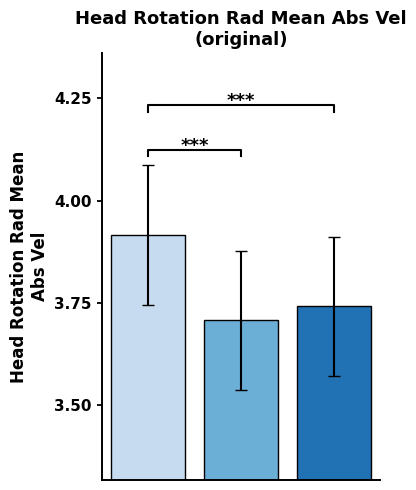

R callback write-console: boundary (singular) fit: see help('isSingular')
  
R callback write-console: Cannot use mode = "kenward-roger" because *pbkrtest* package is not installed
  
R callback write-console: Cannot use mode = "kenward-roger" because *pbkrtest* package is not installed
  
R callback write-console: Cannot use mode = "kenward-roger" because *pbkrtest* package is not installed
  
R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1:   
R callback write-console: In ptukey(sqrt(2) * abst, fam.size, zapsmall(df), lower.tail = FALSE) :  
R callback write-console: 
   
R callback write-console:  NaNs produced
  
R callback write-console: 2:   
R callback write-console: In ptukey(sqrt(2) * abst, fam.size, zapsmall(df), lower.tail = FALSE) :  
R callback write-console: 
   
R callback write-console:  NaNs produced
  


Means for head_rotation_rad_rms:
  H: 1.000
  L: 1.000
  M: 1.000

=== original_head_rotation_rad_rms (R lmerTest) ===
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dv ~ condition + session_order_numeric + window_index + (1 |  
    participant_id)
   Data: dat

REML criterion at convergence: -155117

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-12.913   0.000   0.000   0.000   6.457 

Random effects:
 Groups         Name        Variance  Std.Dev. 
 participant_id (Intercept) 0.000e+00 0.000e+00
 Residual                   1.183e-33 3.439e-17
Number of obs: 2131, groups:  participant_id, 48

Fixed effects:
                        Estimate Std. Error         df    t value Pr(>|t|)
(Intercept)            1.000e+00  2.649e-18  1.057e-19  3.775e+17        1
condition.L            7.264e-17  1.294e-18  1.057e-19  5.614e+01        1
condition.Q           -3.674e-17  1.287e-18  1.057e-19 -2.855e+01        1
session_order_numeric 

R callback write-console: Cannot use mode = "kenward-roger" because *pbkrtest* package is not installed
  


ValueError: Axis limits cannot be NaN or Inf

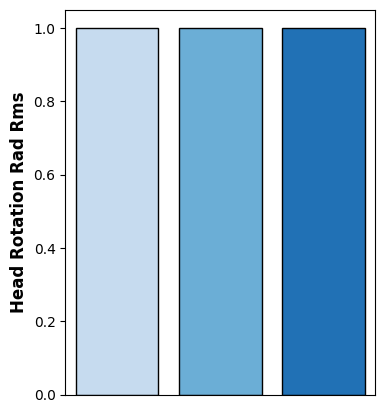

In [5]:
# Filter methods if user selected a subset
methods_to_analyze = pose_metrics_df["method"].unique()
results = {}

for method in methods_to_analyze:
    df_method = pose_metrics_df[pose_metrics_df["method"] == method]
    print(f"\nAnalyzing {method} normalization method...")
    results[method] = {}

    for metric in metric_cols:
        # Skip if column doesn't exist
        if metric not in df_method.columns:
            continue
        # Skip if column is all NaN
        if df_method[metric].dropna().empty:
            continue

        label = metric.replace("_", " ").title()
        pvals, means, cis = run_rpy2_lmer(df_method, metric, f"{method}_{metric}")

        if pvals is not None:
            results[method][metric] = {
                "pvals": pvals,
                "means": means,
                "cis": cis,
                "label": label
            }

            # Plots
            conds = ["L", "M", "H"]
            mean_vals = [means.get(c, float('nan')) for c in conds]
            sems = [(cis[c][1] - cis[c][0]) / 3.92 if c in cis else float('nan') for c in conds]
            pval_list = [
                pvals.get(("L", "M"), 1.0),
                pvals.get(("L", "H"), 1.0),
                pvals.get(("M", "H"), 1.0)
            ]

            fig, ax = plt.subplots(figsize=(4, 5))
            barplot_ax(ax, mean_vals, sems, pval_list, ylabel=label, metric_name=metric)
            ax.set_title(f"{label}\n({method})", fontsize=13, weight='bold')
            plt.tight_layout()
            plt.show()

print(f"\nAnalysis complete! Processed {sum(len(r) for r in results.values())} metrics total")